In [3]:
import numpy as np
import torch
import sys
sys.path.append('../../mist-base/GW')
import gw150814_simulator as gs

class Simulator_Additive:
    def __init__(self, Nbins, sigma, bounds=5, fraction=None, 
                 sample_fraction=False, bkg=False, device='cpu', 
                 dtype=torch.float64, mode=None, bump = None,
                 specific_theta = None, frange = [None,None],
                 lock_amp = False, lock_mu=False, lock_sigma=False):
        """
        Args:
        - Nbins (int): Number of bins in the histogram.
        - sigma (float): Standard deviation of the Gaussian noise.
        - bounds (float): Bounds for the uniform distribution of the additive noise.
        - fraction (float): Fraction of bins to be perturbed by the additive noise. If None, just one bin is perturbed.
        - bkg (bool): If True, the simulator generates a bkground signal.
        - device (str): Device to run the tensors on.
        - dtype (torch.dtype): Data type of the tensors.
        - mode (str): white, complex or gw - simulation generation mode
        - bump (str or list): None, det or [a,m,s] - whether to generate a bump as mu and whether it is stochastic or not
        """
        self.mode = mode
        if self.mode == 'gw':
            default = gs.defaults
            default['posterior_samples_path'] = '../../mist-base/GW/GW150814_posterior_samples.npz'
            self.gw = gs.GW150814(settings=default)

            self.Nbins = len(self.gw.frequencies)
            

            self.frange = [20,1024] if (frange[0] == None) else frange
            self.mask = (self.gw.frequencies>=self.frange[0])&(self.gw.frequencies<self.frange[1])
            self.grid = self.gw.frequencies
            self.grid_chopped = self.grid[self.mask]
            self.psdnorm = torch.tensor(np.sqrt(self.gw.psd))
        else: 
            self.Nbins = Nbins
            self.grid = torch.linspace(0, self.Nbins, self.Nbins, device=device, dtype=dtype)

            self.frange = [0,self.Nbins] if (frange[0] == None) else frange
            self.mask = (self.grid>=self.frange[0])&(self.grid<self.frange[1])
            self.grid_chopped = self.grid[self.mask]

        self.device = device
        self.dtype = dtype
        self.sigma = sigma
        self.bounds = np.abs(bounds)
        self.bkg = bkg
        self.fraction = fraction
        self.sample_fraction = sample_fraction


        self.bump = bump

        self.lock_amp = lock_amp
        self.lock_mu = lock_mu
        self.lock_sigma = lock_sigma

        self.spec_theta = specific_theta

    ########### GW SETUP STUFF #################

    def _fd_noise(self,nsims):
        xshape = [nsims, len(self.grid)]
        white_noise_fd = (
            np.random.normal(size=xshape)
            + 1j * np.random.normal(size=xshape)
        ) / np.sqrt(2)
        prefactor = np.sqrt(self.gw.psd) / np.sqrt(2 * self.gw.delta_f)
        noise_fd = prefactor * white_noise_fd
        # noise_fd_filtered = noise_fd * self.gw.filter
        torch_mask = torch.from_numpy(np.array(self.mask))
        return (torch.tensor(np.abs(noise_fd))/self.psdnorm)[:,torch_mask]
    
    def _fd_theta_batched(self,nsims):
        choices = np.random.choice(self.gw.posterior_array.shape[0], size=nsims, replace=True)
        params_batch = self.gw.posterior_array[choices]
        return params_batch

    def _fd_waveform_batched(self, params_batch):
        theta_ripple_batch = jnp.array(params_batch[:, :8])
        ra_batch, dec_batch, psi_batch = params_batch[:, 8], params_batch[:, 9], params_batch[:, 10]
        batched_waveform = jax.vmap(self.gw.call_waveform)
        batched_detector_response = jax.vmap(
            self.gw.detector.fd_response,
            in_axes=(None, {'p': 0, 'c': 0}, {'ra': 0, 'dec': 0, 'psi': 0, 'gmst': None})
        )
        hp_batch, hc_batch = batched_waveform(theta_ripple_batch)
        wf_fd_batch = batched_detector_response(
            self.gw.frequencies,
            {"p": hp_batch, "c": hc_batch},
            {"ra": ra_batch, "dec": dec_batch, "psi": psi_batch, "gmst": self.gw.gmst},
        )
        wf_fd_block = torch.from_numpy(np.array(wf_fd_batch))
        torch_mask = torch.from_numpy(np.array(self.mask))
        return (torch.abs(wf_fd_block) / self.psdnorm)[:,torch_mask]
    
    ############### STOCHAISTIC GAUSSIAN SETUP STUFF ############

    def _gauss(self, x: torch.Tensor, m, amp, sigma) -> torch.Tensor:
        return amp * np.exp(-0.5 * ((x - m) / sigma) ** 2)
    
    def _gauss_theta_batched(self,nsims):
        theta_default = torch.Tensor([self.Nbins/2,3,self.Nbins/24]) if (self.spec_theta == None) else self.spec_theta
        theta_locked = theta_default*torch.ones(nsims, 3)
        if self.bump != 'stoch':
            return theta_locked
        else:
            norm = torch.tensor([self.Nbins/5,1,8])
            start = torch.tensor([self.Nbins/2, 3,self.Nbins/24])
            theta = torch.abs(torch.rand(nsims, 3, device=self.device, dtype=self.dtype) * norm + start)
            locks = torch.tensor([self.lock_mu, self.lock_amp, self.lock_sigma], device=self.device, dtype=torch.bool)
            output = torch.where(locks, theta_locked, theta)
            return output
    
    def _gauss_mu_batched(self,nsims,theta:torch.Tensor):
        # grid = torch.arange(self.Nbins).unsqueeze(0)*torch.ones([nsims,self.Nbins])
        grid = self.grid_chopped*torch.ones([nsims,len(self.grid_chopped)])
        mu = self._gauss(grid, theta[:,0].unsqueeze(-1), theta[:,1].unsqueeze(-1), theta[:,2].unsqueeze(-1))
        torch_mask = torch.as_tensor(self.mask)
        return (mu)[:,torch_mask]
    
    ######### GET COMMANDS ############

    def get_theta(self, Nsims: int) -> torch.Tensor:
        if self.mode == 'gw':
            return self._fd_theta_batched(nsims=Nsims)
        else:
            return self._gauss_theta_batched(nsims=Nsims)

    def get_mu(self, Theta: torch.Tensor) -> torch.Tensor:
        Nsims = Theta.shape[0]
        if self.mode == 'gw':
            return self._fd_waveform_batched(Theta)
        else:
            return self._gauss_mu_batched(Nsims, Theta)
    
    def get_noise_H0(self, Nsims):
        x_shape = (Nsims, len(self.grid_chopped))
        if self.mode == 'gw':
            return self._fd_noise(nsims=Nsims)
        elif self.mode == 'complex':
            noise = torch.complex(torch.randn(x_shape), torch.randn(x_shape))
            return torch.abs(noise).to(self.dtype)
        else:
            return (torch.randn(x_shape, device=self.device, dtype=self.dtype) * self.sigma).to(self.dtype)

    def get_x_H0(self, Nsims: int, mu: torch.Tensor = 0) -> torch.Tensor:
        return mu + self.get_noise_H0(Nsims=Nsims)

    def get_ni(self, x: torch.Tensor) -> torch.Tensor:
        if self.fraction is None:
            """Standard basis vectors"""
            batch_size, N_bins = x.shape
            ni = torch.zeros(batch_size, N_bins, device=self.device, dtype=self.dtype)
            indices = torch.randint(0, N_bins, (batch_size,), device=self.device)
            ni[torch.arange(batch_size), indices] = 1
        else:
            """Fraction of bins are distorted"""
            if self.sample_fraction:
                fr = np.random.uniform(0.01, self.fraction)
            else:   
                fr = self.fraction
            prob = fr
            random_vals = torch.rand_like(x)
            ni = (random_vals < prob).type(self.dtype)  # fr% chance
        return ni
    
    def get_epsilon(self, ni: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return (2 * self.bounds * torch.rand(x.shape, device=self.device, dtype=self.dtype) - self.bounds) * ni # returns on [-self.bounds, self.bounds)
    
    def get_x_Hi(self, epsilon: torch.Tensor, ni: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return x + epsilon * ni
    
    def _sample(self, Nsims: int) -> dict:
        sample = {}
        x_shape = (Nsims, len(self.grid_chopped))
        if self.bkg:
            theta = self.get_theta(Nsims)
            mu = self.get_mu(theta)
            sample['theta'] = theta
            sample['mu'] = mu
            x0 = self.get_x_H0(Nsims, mu)
        else:
            mu = torch.zeros(x_shape).to(dtype=self.dtype)
            sample['mu'] = mu.to(dtype=self.dtype)
            x0 = self.get_x_H0(Nsims, 0).to(dtype=self.dtype)
        ni = self.get_ni(x0).to(dtype=self.dtype)
        epsilon = self.get_epsilon(ni, x0).to(dtype=self.dtype)
        xi = self.get_x_Hi(epsilon, ni, x0).to(dtype=self.dtype)
        
        sample.update({'x0': x0,'epsilon': epsilon, 'ni': ni, 'xi': xi})
        return sample
    
    def _resample(self, sample: dict) -> dict:
        Nsims = sample['x0'].shape[0] if sample['x0'].ndim == 2 else 1
        if self.bkg:
            sample['x0'] = self.get_x_H0(Nsims, sample['mu'])
        else:  
            sample['x0'] = self.get_x_H0(Nsims, 0)
        sample['ni'] = self.get_ni(sample['x0'])
        sample['epsilon'] = self.get_epsilon(sample['ni'], sample['x0'])
        sample['xi'] = self.get_x_Hi(sample['epsilon'], sample['ni'], sample['x0'])
        return sample
    
    def sample(self, Nsims: int = 1) -> dict:
        sample = self._sample(Nsims)
        return sample

In [4]:
import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import jax
import jax.numpy as jnp
pf.housestyle_rcparams()

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

# from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

from scipy.stats import gaussian_kde

import logging

mycolors = ['#570f6d', "#9e8f92", '#f98e08']
folly = '#ff004f'

In [6]:
Nsims = 100_000
Nbins = 100
train_bounds = 5

simulator = Simulator_Additive(100,1,5,0.02,mode='gw', bkg=True)

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


In [7]:

N_mc = 2e6

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
data_bin_H0 = []

for _ in tqdm(range(N_batch)):
    dummy = np.ones([124,len(simulator.grid)])*simulator.grid
    mc_samples = simulator._fd_noise(124)
    data_bin_H0.append(mc_samples)
    
data_bin_H0 = np.concatenate(data_bin_H0)


### Start by ascertaining the data distribution ###
from scipy.stats import norm
def get_quantiles(indata, nsig:int, sigma_key=False):
    data = np.sort(indata)
    sigmas = np.arange(-nsig,nsig+1,1)
    indices = (len(data)*norm.cdf(sigmas)).astype(int)
    if not sigma_key:
        return data[indices]
    else:
        return np.array([data[indices],sigmas])
    
alldata = data_bin_H0.flatten()
mean = np.mean(alldata)
quantiles = get_quantiles(alldata, 3)
quantiles_long = get_quantiles(alldata,5)

quantiles = np.array([0.05199686, 0.2145543,  0.58780088, 1.17737921, 1.91882754,
 2.75067576, 3.63463655])

quantiles_long = np.array([7.11978022e-04, 7.96148769e-03, 5.19968566e-02, 2.14554300e-01,
 5.87800876e-01, 1.17737921e+00, 1.91882754e+00, 2.75067576e+00,
 3.63463655e+00, 4.55164698e+00, 5.49045819e+00])

100%|██████████| 488/488 [00:13<00:00, 37.45it/s]


In [9]:
# dummy = np.ones([124,len(simulator.grid)])*simulator.grid
# a = simulator._fd_noise(124)
# pb = simulator._fd_theta_batched(124)
# b = simulator._fd_waveform_batched(pb)

# fig,ax = pf.create_plot()
# ax2 = fig.add_axes((1,0,0.3,1))
# plt.setp(ax2.get_yticklabels(), visible=False)

# ax.plot(simulator.grid,a[0], color='#ff004f', lw=0.5, alpha=1)

# ax.set_ylabel(r'$\tilde{d}_w(f)$')
# ax.set_xlabel(r'$f$')
# ax.set_xlim(1, 1024)

# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='#ff004f')
# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='black', histtype='step')
# ax2.set_xticks([0.25,0.50])
# ax2.set_xlim([0,0.69])

# for i,q in enumerate(quantiles_long):
#     extra = np.linspace(-100,2148, 100)
#     ax.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)
#     ax2.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)

# ax.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)
# ax2.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)


# pf.fix_plot([ax,ax2])

In [6]:
# dummy = np.ones([124,len(simulator.grid)])*simulator.grid
# a = simulator._fd_noise(124)
# pb = simulator._fd_theta_batched(124)
# b = simulator._fd_waveform_batched(pb)

# fig,ax = pf.create_plot()
# ax2 = fig.add_axes((1,0,0.3,1), sharey=ax)
# plt.setp(ax2.get_yticklabels(), visible=False)

# ax.plot(simulator.grid,a[0]+b[0], color='#ff004f', lw=0.5, alpha=1)

# ax.set_ylabel(r'$\tilde{d}_w(f)$')
# ax.set_xlabel(r'$f$')
# ax.set_xlim(20, 1024)
# ax.set_ylim(0,6)

# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='#ff004f')
# ax2.hist(a[0], bins=50, orientation='horizontal', density=True, color='black', histtype='step')
# ax2.set_xticks([0.25,0.50])
# ax2.set_xlim([0,0.69])

# for i,q in enumerate(quantiles_long):
#     extra = np.linspace(-100,2148, 100)
#     ax.fill_between(simulator.grid, quantiles_long[i]+b[0], quantiles_long[-i]+b[0],  color='#b0b0b0', alpha=0.15, zorder=-10)
#     ax2.fill_between(extra, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15, zorder=-10)

# ax.plot(simulator.grid, quantiles[3]+b[0], lw=3, c="#7f7f7f", zorder=-10)
# ax2.plot(np.linspace(-100,2148, 100), quantiles[3]*np.ones(100), lw=3, c="#7f7f7f", zorder=-10)


# pf.fix_plot([ax,ax2])

/tmp/ipykernel_4030490/1856796270.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_4030490/1856796270.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


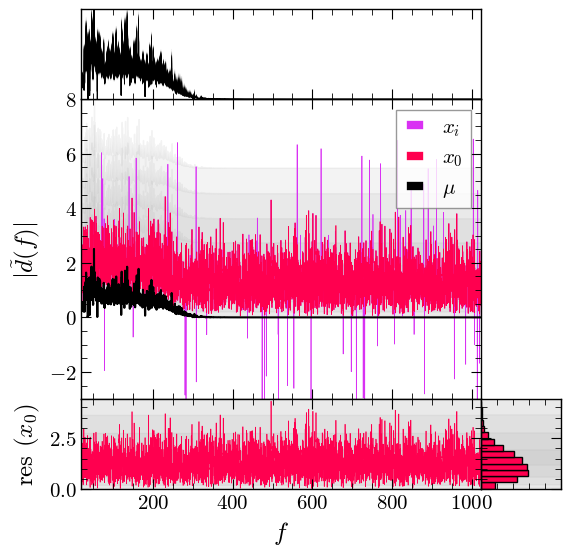

In [7]:
import jax
import jax.numpy as jnp

# samples = simulator.sample(124)  
obs = simulator.sample(1)
# simulator.get_theta(100)

test = simulator.sample(1)

pf.housestyle_rcparams()
fig, ax1 = pf.create_plot()

plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = fig.add_axes((0,-.3,1,0.3), sharex=ax1)
ax3 = fig.add_axes((1,-.3,0.2,0.3), sharey=ax2)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
ax4 = fig.add_axes((0,1,1,0.3), sharex=ax1)
plt.setp(ax4.get_xticklabels(), visible=False)

ax1.plot(simulator.grid_chopped,test['xi'][0], label=r'$x_i$', color="#d931f3", lw=0.5)
ax1.plot(simulator.grid_chopped,test['x0'][0], label=r'$x_0$', color='#ff004f', lw=0.5)
ax1.plot(simulator.grid_chopped,test['mu'][0], label=r'$\mu$', color='black')
ax1.set_ylabel(r'$|\tilde{d}(f)|$')
ax1.set_ylim([-3,8])
ax1.legend(loc='upper right')
ax1.set_xlim(20, 1024)


resd = test['x0'][0]-test['mu'][0]
ax2.plot(simulator.grid_chopped,resd, color='#ff004f', lw=0.5)
ax2.set_xlabel(r'$f$')
ax2.set_ylabel(r'res ($x_0$)')
ax2.set_ylim([0,4.4])
for i in range(1,6):
    ax1.fill_between(simulator.grid_chopped, quantiles_long[i]+test['mu'][0], quantiles_long[-i]+test['mu'][0],  color='#b0b0b0', alpha=0.15)
    ax2.fill_between(simulator.grid_chopped, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15)
    ax3.fill_between(simulator.grid, quantiles_long[i], quantiles_long[-i],  color='#b0b0b0', alpha=0.15)

ax3.hist(resd, orientation='horizontal', bins=14, edgecolor='black', color='#ff004f', density=True)
ax3.set_xlim([0,1])

for i in range(100):
    ax4.plot(simulator.grid_chopped,simulator.sample(1)['mu'][0], lw=0.5, color='black', alpha=0.05)

ax4.set_yticks([])
ax4.set_ylim([0,2])
pf.fix_plot([ax1,ax2, ax3,ax4])
plt.tight_layout()

plt.tight_layout()


In [8]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_epsilon(torch.nn.Module):
    def __init__(self, nbins):
        super().__init__()
        
        self.nbins = nbins
        self.logvariance_epsilon = torch.nn.Parameter(torch.ones(self.nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 
                
    def epsilon(self, x):
        return self.net(x.unsqueeze(1)).squeeze(1) # x-net
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance_epsilon.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance_epsilon.detach().exp().sqrt().mean(-1) * 5

        
    def forward(self, x):
        
        x0_block = x['x0']
        mu_block = x['mu']
        ni = x['ni']
        
        ###########################################
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, 
                                                           device= x['x'].device, 
                                                           dtype= x['x'].dtype) - self.bounds()) * ni
        ###########################################

        data = x0_block+epsilon_sim

        # net evaluation_e
        net_epsilon = self.epsilon(data)
        mask = ( ni != 0 )  
        squared_error_e = (net_epsilon - epsilon_sim)**2                                         # [B, N_bins]
        l_e = squared_error_e / (self.logvariance_epsilon.exp() + 1e-21) + self.logvariance_epsilon                    # [B, N_bins]
        l_e_return = (l_e * mask.float()).sum() * 0.5
        
        # combine
        return l_e_return

    

In [17]:
batch_size = 124

dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size, num_workers=0)

network_epsilon = Network_epsilon(nbins=4016)
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | Network_epsilon | 70.4 K | train
--------------------------------------------------
70.4 K    Trainable params
0         Non-trainable params
70.4 K    Total params
0.282     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
/data/tgh35/summer25/cam_venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argu

Training: |          | 0/? [00:00<?, ?it/s]

TypeError: Cannot interpret 'Array([0.28720303], dtype=float64)' as a data type

In [ ]:
torch.save(network_epsilon, f'networks/network_GW1_complex')
torch.save(model, f'networks/model_GW1_complex')
netid = 'GW1'

In [ ]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout()
plt.savefig(f'figs/{netid}/bounds.png', dpi=300)
plt.tight_layout();

# Distotions enveloping the data
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
axs = axs.flatten()
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
        for j in range(10):
            sample = simulator.sample(1)
            ni = sample['ni']
            # axs[i_b].plot(sample['mu'][0].cpu(), c='k', ls='--')
            epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
            data =  sample['x0'] + epsilon_sim * ni
            axs[i_b].plot(data[0].cpu(), c='C0', alpha=0.4)
plt.tight_layout()
plt.savefig(f'figs/{netid}/history.png', dpi=300)


In [ ]:


network_epsilon.cuda()
N_mc = 2e6

obs = simulator.sample(1)
ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)

ts_bin_H0_epsilon = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch =  (network_epsilon.snr(mc_samples['x0'].cuda())**2).detach().cpu().numpy()
    ts_bin_H0_epsilon.append(ts_batch)
    
ts_bin_H0_epsilon = np.concatenate(ts_bin_H0_epsilon)


In [ ]:
def pvalue_grid_eps(dat):
    eps_t_mean = np.mean(ts_bin_H0_epsilon, axis=0)
    eps_t_ref = ts_bin_H0_epsilon - eps_t_mean
    counts = np.sum(eps_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(eps_t_ref) + 1)

def pvalue_grid_BCE(dat):
    BCE_t_mean = np.mean(ts_bin_H0_BCE, axis=0)
    BCE_t_ref = ts_bin_H0_BCE - BCE_t_mean
    counts = np.sum(BCE_t_ref >= dat[:, np.newaxis, :], axis=1)
    return (counts + 1) / (len(BCE_t_ref) + 1)

def chop_middle(array, remove=5, linemode=True):
    if len(array)%2==0:
        mid_u = int(len(array)/4)
        mid_d = mid_u -1
        if not linemode:
            return np.concatenate([array[:mid_d-remove], array[mid_u+remove:]])
        else:
            return array[:mid_d-remove] , array[mid_u+remove:], array[mid_u]
    else:
        mid = len(array)//2
        if not linemode:
            return np.concatenate([array[:mid-remove], array[mid+remove:]])
        else:
            return array[:mid-remove], array[mid+remove:], array[mid]
        
def get_snr2(input:dict):
    target = input['x']
    snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy()**2 
    return snr2_nn

def local_do_ticks(list_of_axes, dir = 'in'):
    for ax in list_of_axes:
        ax.minorticks_on()
        ax.tick_params(top=True,right=True, direction=dir, length=7, which='major')
        ax.tick_params(top=True,right=True, direction=dir, length=4, which='minor')

def local_fix_frame(ax):
    ax.tick_params(color='black', labelcolor='black')
    ax.spines[:].set_color('black')
    ax.spines[:].set_linewidth(1)
    return True

def local_fix_plot(a, tickdir ='in'):
    for axes in a:
        axes.grid(False)
        local_do_ticks([axes], tickdir)
        local_fix_frame(axes)
    return True

In [ ]:
###### SET UP GRID ######
positions = torch.arange(0, Nbins, 1).to(dtype=simulator.dtype)
amplitudes = torch.linspace(-3, 10, 80).to(dtype=simulator.dtype)

position_grid, amplitude_grid = torch.meshgrid(positions,amplitudes)
b = {'x':amplitude_grid.T}

###### DO BCE STATS ######
a = b['x']
s = get_snr2(b)
dat = [a,s]


fig, ax1 = pf.create_plot()
ax1.set_xlabel(r'$f$')
ax2 = fig.add_axes((1.05, 0,0.1,1))

# ax3 = fig.add_axes((0, 1.1,1,1))
# plt.setp(ax3.get_xticklabels(), visible=False)
# ax4 = fig.add_axes((1.05, 1.1,0.1,1))

axs = [ax1,ax2]


dat = [pvalue_grid_eps(s)]
lab =  [r'$\mathrm{log}_{10}($p$_{i, \mathrm{SNR}})$']

labcolour = "#000000"

obs = simulator.sample(100)


for q in range(1):
    mesh = axs[2*q].pcolormesh(position_grid.T, amplitude_grid.T, np.log10(dat[q]), cmap='magma', vmin=-8)
    fig.colorbar(mesh,cax=axs[2*q+1], shrink=0.8, label=lab[q])
    axs[2*q+1].set_ylim([-6.5,0])

    for j in range(2):
        axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0])[j], color=labcolour, linewidth=3)
        for i in range(5):
            alp = .5+(i/8)
            axs[2*q].plot(chop_middle(positions)[j], chop_middle(obs['mu'][0]+quantiles[-i])[j], color=labcolour, alpha=alp)

    x = 25
    axs[2*q].text(x,obs['mu'][0][int(x)], r'$\mu$', color=labcolour, size=20)
    sigs = [r'$+3\sigma$',r'$+2\sigma$',r'$+\sigma$',r'$\bar{x}_0$']
    x2 = 25
    ff = torch.Tensor([0,0,0,-1])
    for i in range(4):
        axs[2*q].text(x2,(obs['mu'][0]+quantiles[-i])[int(x2)], sigs[i-1], color=labcolour, size=12, ha='center')  

    axs[2*q].set_ylabel(r'$\tilde{d}(f)$')

local_fix_plot(axs, tickdir='out')

plt.tight_layout()
plt.savefig(f'figs/{netid}/pmaps.png', dpi=700, bbox_inches = 'tight')
